# Aim of code

Script for fitting disentanglement time at 298K using data at 600-800K.
No restriction of a parameter in curver fit.


In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
state='MSM3'
# List of FPT at each temperature that protein unfold, Criteria: Q <= 0.3 for 1000 ps
FPT_dict = {
    'FPT_600' : np.array([ 2.6, 3.37, 3.44, 3.18, 3.65, 2.14, 1.31, 7.22, 1.21, 1.66, 4.5, 10.4, 2.64, 2.29, 4.71, 1.49, 5.56, 2.81, 4.0, 5.85, 2.59, 4.81, 2.89, 6.32, 3.7, 3.19, 4.27, 7.6, 8.2, 5.06, 2.15, 4.52, 6.78, 2.82, 2.19, 2.09, 5.81, 3.11, 5.91, 2.62, 2.95, 6.84, 4.9, 4.58, 5.57, 9.72, 1.08, 4.65, 1.19, 1.02]),
    'FPT_650' : np.array([ 1.11, 2.2, 1.09, 3.03, 1.3, 0.87, 1.41, 0.76, 1.78, 1.03, 2.38, 0.92, 1.77, 1.7, 2.08, 1.22, 1.65, 3.11, 0.76, 1.0, 1.06, 1.94, 1.06, 1.77, 1.38, 0.87, 0.86, 1.65, 1.77, 0.95, 1.33, 1.18, 1.61, 0.66, 0.81, 1.01, 1.46, 1.07, 1.43, 1.26, 1.75, 1.8, 0.84, 0.8, 1.4, 0.81, 1.16, 1.05, 1.83, 2.77]),
    'FPT_700' : np.array([ 0.45, 0.47, 0.29, 0.53, 0.87, 0.48, 0.71, 0.75, 0.47, 0.38, 0.74, 0.61, 0.59, 0.33, 0.68, 0.49, 0.73, 0.37, 0.64, 0.5, 0.44, 0.57, 0.48, 0.43, 0.86, 0.76, 0.47, 0.99, 0.53, 0.67, 1.02, 0.48, 0.76, 0.59, 0.47, 0.17, 0.6, 0.53, 0.93, 0.48, 0.6, 0.63, 0.44, 0.63, 0.56, 0.49, 0.85, 0.56, 0.78, 0.49]),
    'FPT_750' : np.array([ 0.45, 0.26, 0.21, 0.42, 0.44, 0.23, 0.42, 0.3, 0.21, 0.3, 0.31, 0.59, 0.21, 0.48, 0.32, 0.33, 0.4, 0.16, 0.19, 0.37, 0.32, 0.27, 0.25, 0.25, 0.35, 0.37, 0.25, 0.25, 0.26, 0.64, 0.27, 0.23, 0.43, 0.47, 0.48, 0.27, 0.51, 0.33, 0.45, 0.25, 0.31, 0.31, 0.38, 0.38, 0.31, 0.41, 0.32, 0.26, 0.25, 0.37]),
    'FPT_800' : np.array([ 0.14, 0.12, 0.17, 0.18, 0.26, 0.2, 0.15, 0.23, 0.16, 0.19, 0.22, 0.37, 0.21, 0.15, 0.2, 0.14, 0.25, 0.17, 0.17, 0.2, 0.26, 0.2, 0.35, 0.24, 0.27, 0.21, 0.22, 0.14, 0.22, 0.24, 0.15, 0.12, 0.15, 0.29, 0.22, 0.14, 0.29, 0.22, 0.15, 0.22, 0.18, 0.34, 0.2, 0.21, 0.26, 0.16, 0.19, 0.24, 0.32, 0.3])
}

In [3]:
# Matplotlib setting
fontsize = 12 # set variable for fontsize
linewidth = 2 # set variable for line width
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['axes.labelsize'] = 'small'
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 4
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['xtick.labelsize'] = 'x-small'
matplotlib.rcParams['ytick.labelsize'] = 'x-small'
matplotlib.rcParams['legend.fontsize'] = 'x-small'
matplotlib.rcParams['figure.dpi'] = 600

# config for matplotlib
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.linewidth'] = 2 #set the value globally

# set tick width
matplotlib.rcParams['xtick.major.size'] = 6
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 6
matplotlib.rcParams['ytick.major.width'] = 2

In [4]:
"""
Functions definition
"""


def cal_Su_list(first_time_zero, time_end, dt=0.01):
    """
    Calculate the survival probability.

    Parameters:
    - first_time_zero (array-like): Array of first passage times.
    - time_end (float): The end time for calculating the survival probability.
    - dt (float, optional): Time step for the calculation. Default is 0.01.

    Returns:
    - ts (numpy.ndarray): Array of time points.
    - survival_probability (numpy.ndarray): Array of survival probabilities corresponding to the time points.
    """
    time_range = np.arange(0, time_end, dt)
    survival_probability = np.array([np.count_nonzero(first_time_zero >= t) / len(first_time_zero) for t in time_range])
    return time_range, survival_probability

def exp_fun(x, k, t0):
    """
    Exponential function used for fitting survival probability.

    Parameters:
    - x (numpy.ndarray): Time variable.
    - k (float): Rate constant.
    - t0 (float): Time offset.

    Returns:
    - numpy.ndarray: The value of the exponential function at time `x`.
    """
    t = x - t0
    t[t < 0] = 0
    return np.exp(-k * t)

def quadratic_fun(x, a, b, c):
    """
    Quadratic function for fitting purposes.

    Parameters:
    - x (numpy.ndarray): Independent variable (1/T).
    - a (float): Quadratic term coefficient.
    - b (float): Linear term coefficient.
    - c (float): Constant term.

    Returns:
    - numpy.ndarray: The value of the quadratic function at `x`.
    """
    return a * x**2 + b * x + c

def get_ln_kapp(FPT):
    """
    Calculate the natural logarithm of the apparent rate (ln_kapp) from the first passage time (FPT) array.

    Parameters:
    - FPT (array-like): First passage time array.

    Returns:
    - float: The natural logarithm of the apparent rate (ln_kapp).
    """
    time_end = np.max(FPT) + 5
    ts, Su_list = cal_Su_list(FPT, time_end)
    kopt, _ = curve_fit(exp_fun, ts, Su_list, bounds=(0, np.inf), maxfev=5000)
    k, t0 = kopt[0], kopt[1]
    kapp = 1e9 / (t0 + 1 / k)
    return np.log(kapp)


def write_SU(FPT, Temp):
    time_end = np.max(FPT) + 5
    ts, Su_list = cal_Su_list(FPT, time_end)
    with open(f'survival_{Temp}.dat', 'w') as f:
        for t, s in zip(ts, Su_list):
            f.write(f'{t:.2f}    {s:.3f}\n')

            

            
def bootstrap_FPT_dict(Temperature_FPT_dict):
    # Create a new dictionary for the random choices
    random_FPT_dict = {}

    # Apply np.random.choice with replacement to each array in the original dictionary
    for key in Temperature_FPT_dict:
        random_FPT_dict[key] = np.random.choice(Temperature_FPT_dict[key], size=len(Temperature_FPT_dict[key]), replace=True)

    # Print the new dictionary with random choices
#     print(random_FPT_dict)
    return random_FPT_dict

def extrapolate_ln_kapp_target_temperature(temperature_list, Temperature_FPT_dict, target_temp=298):
    """
    Extrapolates the natural logarithm of kapp (ln(kapp)) for a target temperature using quadratic fitting.
    
    Parameters:
    temperature_list (list of float): List of temperatures to be used for fitting.
    Temperature_FPT_dict (dict): Dictionary containing FPT values for each temperature. Keys should be formatted as 'FPT_<temperature>'.
    target_temp (float, optional): The target temperature for which ln(kapp) is to be extrapolated. Default is 298 K.
    
    Returns:
    tuple: 
        - numpy.ndarray: Inverse temperatures including the target temperature.
        - numpy.ndarray: ln(kapp) values including the extrapolated value for the target temperature.
        - float: Coefficient of determination (R^2) for the quadratic fit.
        - numpy.ndarray: Coefficients of the quadratic function (a, b, c).
    """
    # Initialize an array to store inverse temperatures and ln(kapp) values
    num_temperatures = len(temperature_list)
    inv_temperature_ln_kapp = np.zeros((num_temperatures + 1, 2))
    
    for i, temperature in enumerate(temperature_list):
        inv_temperature_ln_kapp[i, 0] = 1/temperature
        inv_temperature_ln_kapp[i, 1] = get_ln_kapp(Temperature_FPT_dict[f'FPT_{temperature}'])
        
    # Fit a quadratic function to the data points (excluding the target temperature)
    kopt_target, _ = curve_fit(quadratic_fun, inv_temperature_ln_kapp[:-1, 0], inv_temperature_ln_kapp[:-1, 1], maxfev=5000)
    
    # Calculate the coefficient of determination (R^2) for the fit
    predicted_ln_kapp = quadratic_fun(inv_temperature_ln_kapp[:-1, 0], *kopt_target)
    cc_target = np.corrcoef(inv_temperature_ln_kapp[:-1, 1], predicted_ln_kapp)[0, 1] ** 2
    
    # Extrapolate ln(kapp) for the target temperature
    ln_kapp_target = quadratic_fun(1 / target_temp, *kopt_target)

    # Add the target temperature and its extrapolated ln(kapp) value to the array
    inv_temperature_ln_kapp[-1,:] = 1/target_temp, ln_kapp_target
    return inv_temperature_ln_kapp[:, 0], inv_temperature_ln_kapp[:, 1], cc_target, kopt_target


def convert_ln_kapp_to_human(ln_kapp, human_type='day'):
    """
    Convert the logarithm of kapp (ln_kapp) to human time.

    Parameters:
    - ln_kapp (float): The natural logarithm of kapp.
    - human_type (str): The desired unit of human time. Can be 'second', 'hour', or 'day'. Default is 'day'.

    Returns:
    - float: The converted time in the specified human time unit.
    """
    # scaled_factor = 143
    
    # Calculate the simulated life time in nanoseconds
    simulated_life_time = 1 / np.exp(ln_kapp)
    
    # Convert simulated life time from nanoseconds to human time
    conversion_factors = {
        'second': 1,
        'hour': 1 / 3600,
        'day': 1 / 86400
    }
    
    if human_type not in conversion_factors:
        raise ValueError("Invalid human_type. Expected one of: 'second', 'hour', 'day'")

    lifetime = simulated_life_time / conversion_factors[human_type]
    return lifetime


In [5]:
target_temp = 298
temperature_list = [800, 750, 700, 650, 600]

In [6]:
mean_res = extrapolate_ln_kapp_target_temperature(temperature_list, FPT_dict)

In [7]:
# bootstrapping
nboot=10000
i=0
ln_kapp_array = np.zeros((len(temperature_list)+1, nboot))
while i < nboot:
    random_FPT_dict = bootstrap_FPT_dict(FPT_dict)
    res = extrapolate_ln_kapp_target_temperature(temperature_list, random_FPT_dict, target_temp)
    print(res[2], res[1][-1])
    if res[2] >= 0.9:
        print(i)
        ln_kapp_array[:,i] = res[1]
        i+=1
    

0.9980578143860938 -13.852547252064543
0
0.9992958771404308 -12.729589865786096
1
0.9992763265722759 -15.97204278812173
2
0.9988561654477662 -9.816146773146261
3
0.9996043603010429 -20.44398769350608
4
0.9974002287055495 -9.102916636762718
5
0.9998273703584295 -15.016926875935713
6
0.9990410739948127 -10.840544530577926
7
0.9988181076611523 -15.174645042509326
8
0.9968242721125055 -7.877688683140359
9
0.9974400356815459 -21.306422459274103
10
0.999650111753235 -4.976403157686654
11
0.9986700554504754 -12.427035087628546
12
0.9977055765978543 -4.38455149856069
13
0.9976813851181731 -8.532999472693348
14
0.9985352630755302 -17.184710586409054
15
0.9999655650348532 -7.514828561802215
16
0.9991370140490474 -14.511074490103589
17
0.9995276641325537 -8.427908251060586
18
0.9988252278701601 -11.203855697382444
19
0.9983453385277501 -20.606307032077623
20
0.9994835351455021 -1.8609323147615946
21
0.9991265783369939 -7.752201294712048
22
0.9986304794852041 -16.19432490372597
23
0.99885283373362

0.9990680403757984 -41.667718442397714
398
0.9986669126661197 -39.283062874728046
399
0.9995508065282482 -36.99342223142981
400
0.9995314818647555 -34.34253455989553
401
0.999524664316195 -32.01062113491757
402
0.9999091703282399 -30.889584007187157
403
0.9975642969114886 -38.23059037135097
404
0.9981961099002948 -32.265055321899816
405
0.9996463044379076 -30.776783042307624
406
0.9998768427518642 -41.44323288543332
407
0.9987617291488127 -24.117704477250722
408
0.9981935473554012 -23.76296682982872
409
0.9990809686226627 -25.756206398411567
410
0.9989822325808124 -38.681837425892446
411
0.9972043782272463 -30.40498068847216
412
0.9990289838625542 -33.247745198526985
413
0.997553421681464 -37.381526905918726
414
0.9999690856634116 -33.782920603291416
415
0.9980915670071988 -35.569477948718934
416
0.999301449900978 -30.15974975937847
417
0.9977421277026389 -31.604556623265786
418
0.9994668516633066 -28.859180728999995
419
0.9985432789663957 -32.385264523444356
420
0.9987041520022469 -30

0.9992713057900638 -38.447315678172984
594
0.9998697773655763 -36.553316506015484
595
0.9996664133803287 -31.225271360266966
596
0.9997689762271417 -32.622316907102125
597
0.9996762355047044 -39.54746194310869
598
0.9971739272799778 -35.33823180232118
599
0.9992611591279245 -33.0337137152222
600
0.9989991511964557 -36.61353723201963
601
0.9995907785790922 -35.324834226318764
602
0.9987149750052771 -30.09276269564169
603
0.9996839629848626 -26.056714777898236
604
0.9988541797347331 -33.42309702227235
605
0.999249040829687 -27.084168697852753
606
0.9997445205754973 -27.95733466504041
607
0.9995388149609549 -34.94193576155379
608
0.9979053993746336 -37.412267121822616
609
0.9984668130631147 -36.704585939583616
610
0.9996587374313084 -24.225285333890096
611
0.9996800749041781 -34.733036000382214
612
0.9997102165085988 -27.6721625233811
613
0.9990275242015544 -31.00727327245057
614
0.9955009299332688 -24.189997942022497
615
0.9997318209919392 -39.71429617008691
616
0.9993978499230974 -29.33

0.9983372421397162 -33.90913921700247
792
0.9995727416337702 -32.00253531477442
793
0.9987665743364785 -28.95451291362483
794
0.9998328181981857 -28.771654293056546
795
0.9989599700145317 -32.38672127972386
796
0.9991460143814249 -38.36198242464594
797
0.9973829661018625 -29.725057349591445
798
0.9990900256842921 -39.17728257557981
799
0.9995315471858724 -39.963657505489536
800
0.9991808485605083 -37.66361628420912
801
0.9945104882498709 -32.1143041896593
802
0.9985610717555368 -32.162268291211795
803
0.9995233767064017 -34.07576845766958
804
0.9988275571021661 -33.18836425352749
805
0.9984520527629474 -37.81468213514364
806
0.9994809751093638 -29.39412792267896
807
0.9990666479519682 -35.30094241691586
808
0.9977912274439558 -31.153861894241356
809
0.9999969211016435 -31.829005729947095
810
0.9984928306148011 -25.990850844654098
811
0.9998058338128768 -28.34399651625501
812
0.999610069340103 -28.514734877923516
813
0.9992720549695993 -38.760679607595925
814
0.9965416828879708 -24.9082

0.999107124908982 -30.20679746833678
990
0.9987555644287558 -34.80217785679949
991
0.9999970932769866 -26.490271964099893
992
0.9995748176565717 -36.139151651735006
993
0.9985531052236214 -21.95027000843214
994
0.9989972494596748 -28.40832933362739
995
0.9971743469049732 -39.095086056919484
996
0.997036218661669 -34.7538317326781
997
0.9994310763552943 -30.748100491572693
998
0.9993830996132161 -30.431063262009296
999
0.9988706907263515 -28.24890984683913
1000
0.9990562302493762 -32.34272959725738
1001
0.9994792196589322 -36.91058693119382
1002
0.9978210525136183 -28.40140717243696
1003
0.9986586339565587 -30.48347728191633
1004
0.9951108908475681 -30.596719255964054
1005
0.9990994369955533 -39.52060730409683
1006
0.9998310875765563 -39.36670631621759
1007
0.9995526323542958 -34.920922670214686
1008
0.9997359465192058 -33.128445582736525
1009
0.9986050010289172 -32.77198992873589
1010
0.9998045122663652 -37.68176016296442
1011
0.9985868878763827 -24.733113176501
1012
0.9991464383520727

0.9996775082453587 -30.28144709968868
1181
0.999107463651875 -35.45526433666039
1182
0.9990486707447933 -32.643122130733545
1183
0.999904890852097 -34.17028795941194
1184
0.9999216211257523 -32.04673991385118
1185
0.9974882446114752 -36.99362662547275
1186
0.9991017653466668 -24.156163118107745
1187
0.9955086026471874 -39.217223847855664
1188
0.9996354800057891 -31.51951417970249
1189
0.9966877341852904 -26.92089063746737
1190
0.999411118933347 -28.076241912066884
1191
0.999519742273561 -32.1965168070889
1192
0.9972436866250889 -36.23484083681066
1193
0.9996005878011334 -36.746799748921916
1194
0.9994974947428402 -28.50433517304117
1195
0.9991706495589354 -30.790606935739113
1196
0.9993992551759093 -36.82485134949861
1197
0.9985015579122082 -29.63349282360332
1198
0.9992404242271662 -32.67249768056471
1199
0.997293564265253 -34.26562849073088
1200
0.9974153305542138 -27.325967133056277
1201
0.9958027998826074 -26.230046563228754
1202
0.9992401655751836 -39.36548662442116
1203
0.9998610

0.9994012019595484 -32.1591205419228
1372
0.996354030172001 -35.56088237019086
1373
0.9997262856843503 -29.699362783072857
1374
0.9987001096929369 -27.69853582525514
1375
0.9991294096179197 -41.442940946096044
1376
0.9964577842323222 -23.70706552512977
1377
0.999906963851928 -36.8170165026527
1378
0.9997260319860027 -30.813193628242733
1379
0.9995395671854591 -30.34400830726627
1380
0.9987931078057618 -34.25124750384392
1381
0.9986051699367725 -25.390730733834385
1382
0.9996379603989594 -39.46424110632022
1383
0.997260273154896 -20.98086573330658
1384
0.9995371496586478 -36.96676863454323
1385
0.9992821552643522 -26.921454284711732
1386
0.9990083506321872 -36.258797040565895
1387
0.9991970292899054 -21.73701524555768
1388
0.994951444795525 -21.647211513388672
1389
0.9961137230038664 -35.06472395706073
1390
0.9995345747290953 -43.89612087841633
1391
0.999022454838373 -30.510133834167824
1392
0.9995426179626886 -40.3334451099645
1393
0.9990463446468029 -37.92178530978811
1394
0.999896838

0.9960502881679159 -23.10133688336759
1563
0.9972669982648925 -36.54517804036055
1564
0.9999948732792178 -35.9588253606531
1565
0.9991122408825419 -34.248911615708636
1566
0.9953546166928028 -35.674518263129556
1567
0.9988530995349914 -34.71972339219268
1568
0.9974422652515924 -39.224792410533595
1569
0.9938226648396504 -24.44960258573036
1570
0.9988165553915636 -31.65792592112939
1571
0.9993263448844315 -34.138642674869914
1572
0.9998288074683551 -37.9774460094751
1573
0.9998046273919584 -32.12931027693355
1574
0.9985754146087682 -29.28689602426453
1575
0.9990929083488117 -31.527575124811687
1576
0.9996969563970758 -36.71306541390899
1577
0.9994230555058312 -38.542592302370835
1578
0.999813483179475 -35.22793032238567
1579
0.9967923686220875 -29.855142382796217
1580
0.9973594025170957 -39.27899644864789
1581
0.9998105668506954 -32.05350976247632
1582
0.9999519538077264 -28.597755686556717
1583
0.9999871790864161 -30.233710708182855
1584
0.999264349445185 -39.47177431756192
1585
0.9990

0.9999037752246932 -31.967993533719245
1757
0.9986161824580123 -33.229087579214855
1758
0.9991569319653191 -32.80039931196739
1759
0.9945659714997316 -31.705113345032075
1760
0.9998314606112284 -24.502343754645278
1761
0.999005090255126 -26.37894107293839
1762
0.9988014533787054 -30.635277347867905
1763
0.9977249775970757 -24.566049834689174
1764
0.9998419760775183 -34.123384343570095
1765
0.9987786271967013 -29.911954915087044
1766
0.9995395559219825 -33.296073137218286
1767
0.9989425225647325 -31.68874598038366
1768
0.9996197899819323 -25.19692048143352
1769
0.999247400779614 -32.505941982727265
1770
0.9981731271095274 -32.722420166757864
1771
0.9969006357367406 -26.89796800811043
1772
0.9995072688319756 -31.239105374130403
1773
0.999231879751643 -35.04273004483163
1774
0.9995171807631995 -40.586115000682945
1775
0.9999991336804417 -36.397408912209094
1776
0.9994374795898407 -28.68015719151001
1777
0.999455080173249 -31.779010050490715
1778
0.999543050335705 -31.784167086821185
1779


0.9990344243076307 -35.671025926127164
1951
0.9988045710660497 -35.16550914443876
1952
0.9996692650886726 -21.71869438856029
1953
0.9997939226118914 -40.516019790060604
1954
0.9995886919990927 -31.526682761718543
1955
0.9989870709008933 -24.93439073678821
1956
0.9976660547689401 -36.56151972476112
1957
0.9977393353682229 -33.59369978952971
1958
0.9991298981395416 -35.52955034205914
1959
0.9989712999147141 -34.83811325703449
1960
0.9992116704116161 -34.45467836420752
1961
0.9998696610313078 -42.26375865535819
1962
0.9999057959003707 -41.52904932782277
1963
0.9985001928172734 -26.816520187729388
1964
0.9997320592984962 -30.96255675460236
1965
0.9991861356398397 -33.76876163111964
1966
0.9960860201456504 -33.13877248799563
1967
0.999428785267411 -38.70829476483992
1968
0.9990964204455147 -38.96763261908506
1969
0.9988512392048358 -26.279411769432567
1970
0.9981256295090252 -23.02039299767033
1971
0.9969158334377708 -30.456986540837264
1972
0.9994112115817625 -29.719561299909707
1973
0.999

0.9998199377794549 -33.59738162996522
2144
0.9987360071408127 -32.76318991752283
2145
0.9999770231276969 -27.949368075114165
2146
0.9974676051509774 -33.52690418654079
2147
0.9994989319743504 -27.62122861271127
2148
0.9955645434520126 -35.73365762727549
2149
0.9991033864217346 -29.157038602899977
2150
0.9983146795001665 -22.9076628194702
2151
0.9998275158160828 -31.31110382364151
2152
0.9971725000020645 -36.38630736395569
2153
0.9993960962802262 -39.07942013153201
2154
0.9997138769849208 -27.035471234761957
2155
0.9988850151800162 -36.37318538661213
2156
0.9998417627404105 -33.93706530756147
2157
0.9981660347481579 -30.195801284163036
2158
0.9979326568029 -27.934218603081565
2159
0.9990968888736347 -43.4686231477704
2160
0.9985580674907626 -39.95452524554713
2161
0.9981587165903911 -35.19991948614462
2162
0.9981806128818321 -35.98760371316828
2163
0.998430719845432 -35.118327413984865
2164
0.999679547419928 -38.261498332990485
2165
0.9996967051394438 -44.609077815122504
2166
0.99951761

0.9991321208775027 -35.537019051852546
2335
0.9999287901963698 -36.63357607308043
2336
0.9992624369599818 -28.83250124775306
2337
0.9996335027708289 -42.758176839484264
2338
0.9998860122211597 -31.483125416580606
2339
0.998450307324655 -21.44048677976515
2340
0.9994125637751917 -39.36593305103341
2341
0.9996776313639842 -39.01718205644979
2342
0.9952769919749387 -30.510997669364357
2343
0.9999031731566096 -36.23331060756274
2344
0.999019623660924 -28.817870365298774
2345
0.9990379947625148 -33.779345822377856
2346
0.9995724906228298 -31.227571059239473
2347
0.999919387556761 -31.51476091208522
2348
0.9995423887032607 -38.482119303176525
2349
0.9940217074701055 -28.14885724607848
2350
0.9998102586404803 -29.169697496796633
2351
0.9994735903383917 -33.64064131518078
2352
0.9983683073308149 -38.277931260080905
2353
0.9991344523267819 -30.65481851675952
2354
0.9976342303830444 -36.545578687151654
2355
0.9994810273706939 -34.91687937315681
2356
0.9991344867798884 -26.993657863529016
2357
0.

0.999871868227556 -34.9377383421008
2530
0.9998632752910007 -29.722732175867392
2531
0.9999685868004755 -32.939158285009654
2532
0.999166998793727 -44.55358392411527
2533
0.9997907786979685 -39.53305894635773
2534
0.998751222477399 -31.991206824633863
2535
0.9994754481957504 -38.415506494635835
2536
0.9990525020535712 -46.499790569645185
2537
0.9990032096838051 -25.328959358101976
2538
0.9995427770760128 -32.49812091601946
2539
0.9992115277178608 -32.607513461327684
2540
0.9993239948907218 -37.928259412837136
2541
0.9999618107919551 -36.453893322154116
2542
0.9982988342080792 -23.024300774089763
2543
0.9978264176092472 -25.15449886701125
2544
0.9989606103038222 -41.03771656030267
2545
0.9994383573141233 -39.23765953420897
2546
0.9990222142552745 -39.82412908784857
2547
0.998525339895134 -36.190729931070216
2548
0.9985386934687903 -31.469049893476107
2549
0.9975609346220186 -28.331513472325465
2550
0.9987088988180817 -32.034658535798435
2551
0.9999485738420283 -32.456478689118505
2552
0

0.9997265007962162 -28.93283402850904
2722
0.9984782635086027 -30.444486302145137
2723
0.9986928409385823 -30.332193693907723
2724
0.9988934746714018 -40.379163460627986
2725
0.9999276021673112 -31.34727704034419
2726
0.9997928223684117 -40.9983203990681
2727
0.9981918745345075 -33.57823854195224
2728
0.9986416654414543 -37.91067702093405
2729
0.9998640787267562 -27.439095618245684
2730
0.9980663741858138 -39.19494692583953
2731
0.99773195637347 -33.1634600700154
2732
0.9996007591686679 -30.277558703651568
2733
0.9997113761061424 -41.33006114252624
2734
0.9998878833433027 -31.797480148898842
2735
0.9998943529075349 -32.82906964868237
2736
0.9992938215664096 -31.415652773796282
2737
0.9998788706293568 -28.982880291040885
2738
0.9992657268881946 -31.32503835841182
2739
0.9985267912205172 -27.41537661461949
2740
0.9982769472913359 -25.88200904957647
2741
0.9981536939504512 -30.66376465682899
2742
0.9995148431335521 -19.422511565932115
2743
0.9994973241643311 -34.57868525584601
2744
0.9977

0.9996905260229965 -23.801941766782726
2917
0.9980742330967043 -34.29006433539177
2918
0.9993850312340793 -35.84383893352905
2919
0.9995917597440296 -34.01445554517637
2920
0.9963772192757208 -40.94462464063424
2921
0.9984049209680852 -29.694433444853246
2922
0.9995901933441194 -37.2339608766564
2923
0.9994355595733788 -30.664654790172232
2924
0.9976138853405586 -31.197753892151614
2925
0.9985595491658035 -27.921037668928644
2926
0.9997107656899497 -25.733530727369374
2927
0.9999798731355518 -34.63719207682826
2928
0.9994859421144662 -36.82725513432939
2929
0.9998714397880653 -36.0496431278571
2930
0.9966420495125639 -24.68157102392396
2931
0.9994607569099546 -35.773001897072795
2932
0.9994553681792745 -37.057298619599806
2933
0.9965864763120704 -21.39743729102279
2934
0.9991790502203642 -14.897645095672841
2935
0.999602196247121 -28.504376948335132
2936
0.9999231425569567 -30.553788836276
2937
0.9997807130815971 -32.123817000216874
2938
0.9982862015309866 -29.528646166883117
2939
0.99

0.9989991133397466 -33.21971373405334
3111
0.9987327799862487 -33.957836995415626
3112
0.9990056883852508 -32.741525552710016
3113
0.9999889488806666 -22.75551414836469
3114
0.9993154660013001 -37.98356474762797
3115
0.9996582596196686 -24.830309391081347
3116
0.9977997043874693 -27.370234741350934
3117
0.9977450090239125 -29.239048538070595
3118
0.9991237277973507 -33.72619969501037
3119
0.9983951787489156 -21.67939073004209
3120
0.9973587723803634 -34.33123225167239
3121
0.9991794129463845 -38.52253088007673
3122
0.9962015767812132 -27.654081408994784
3123
0.9996039235096311 -40.45908412189567
3124
0.9969597073975004 -37.30748493724313
3125
0.9985076212878456 -28.298092197814345
3126
0.9999811899682866 -42.86032929156034
3127
0.9996445207280465 -35.45840357587804
3128
0.9994006931407448 -32.23467950582846
3129
0.9992486907385396 -27.551500592944457
3130
0.9999891952391448 -38.36943532268061
3131
0.9994531634668373 -27.844797495124336
3132
0.9975173743895804 -34.747449094751126
3133
0

0.9995538939060845 -30.82716452529147
3305
0.9993441201273833 -29.57289056573405
3306
0.9986522358271953 -40.25204438547064
3307
0.9997978919965367 -21.419980287386494
3308
0.999169897855783 -27.941738451418207
3309
0.9952981964106118 -34.384096376454366
3310
0.9998195924731028 -30.690924289519533
3311
0.9996234791536508 -25.997719884106697
3312
0.9998566159026228 -30.695049080520725
3313
0.9992074364635513 -33.28556122180442
3314
0.9992230599081886 -39.74191775878814
3315
0.9989281747121697 -34.950802419768294
3316
0.999843592019725 -38.79111486183871
3317
0.9999089139223848 -34.55886503277165
3318
0.9988121867849087 -34.971751064486135
3319
0.9993323220536812 -40.48163363823717
3320
0.999234922391698 -31.99651771763075
3321
0.9983922104473113 -30.316661053850158
3322
0.9996069284458997 -29.822802580710835
3323
0.9994084288011126 -35.69175526091809
3324
0.9990734534286797 -37.5591322193919
3325
0.997117603630575 -26.656690914874762
3326
0.9999167477792947 -29.574670689707464
3327
0.99

0.9961032913343119 -22.11102928687309
3499
0.9969430696947569 -28.018922700525106
3500
0.9985954962457616 -22.52975749455952
3501
0.9984602970743373 -35.87856089250731
3502
0.9997898663028039 -38.66119453427896
3503
0.9997600707662503 -39.21572393923098
3504
0.9983666750514081 -32.98387114436558
3505
0.9999774462322694 -42.617015771565
3506
0.9998189001764655 -34.52206659392905
3507
0.998079073133044 -31.13586438561346
3508
0.9994963881981631 -35.50791851839014
3509
0.9977169577746511 -31.462247906441963
3510
0.999835291780722 -33.03890734863586
3511
0.9997385481239772 -31.03534678866253
3512
0.999036050022591 -31.10733063440981
3513
0.999235971034833 -30.630617983412183
3514
0.9937011054218449 -17.66102080152996
3515
0.9988163113268311 -27.014122205245634
3516
0.9988435634451529 -38.09860752170386
3517
0.9996511442026803 -29.610997172289647
3518
0.9976173348244831 -33.31130647810033
3519
0.999383160567991 -35.685126479090464
3520
0.9981348158480386 -32.713910998470325
3521
0.997687210

0.9994397272467044 -32.19454864787057
3689
0.9994036667245461 -31.732944055508046
3690
0.9998762112042505 -29.69769671222599
3691
0.9999197002403009 -27.914363407416154
3692
0.9995719034729676 -40.40651189849886
3693
0.9994196864902507 -29.52858827103782
3694
0.9974234961978237 -34.67410806583865
3695
0.9999212555972463 -42.27544660279249
3696
0.9980653800850524 -30.388527564105118
3697
0.998891055349064 -27.47227264550743
3698
0.9995894980685192 -38.09510803896614
3699
0.9997166050210405 -26.66640338933933
3700
0.9994833546341695 -42.25906849255696
3701
0.9976854565538822 -36.81922001203167
3702
0.9999696536436328 -36.5513249498107
3703
0.9997333125302839 -18.109643258433465
3704
0.9984948459642757 -41.74876772059563
3705
0.9998406483992054 -32.85337378512742
3706
0.998620436819439 -37.32887730327229
3707
0.9997453508434397 -31.908198113105307
3708
0.9997626108559766 -41.1743545757757
3709
0.9995264721438841 -28.76595002607234
3710
0.9997607080854543 -42.8710878165222
3711
0.999334866

0.9995757884481734 -27.29091041511702
3879
0.9999884240345618 -24.40168149997117
3880
0.9955708890095883 -37.78780210821957
3881
0.9992886304080665 -29.591608030549615
3882
0.9999595022441166 -32.45293967013253
3883
0.9991782703196812 -35.040207304502445
3884
0.9994681892110333 -34.8368872269406
3885
0.9967157058416682 -24.4064678025496
3886
0.9959296091245453 -31.81397171850431
3887
0.9994493456463223 -37.088982010543155
3888
0.9997925624591852 -45.886475459386574
3889
0.9992806943108474 -30.79534528244044
3890
0.996022002359006 -27.992736897373412
3891
0.9991609401148485 -26.900463531797932
3892
0.9989673857605474 -30.59563968405277
3893
0.9988203588977297 -38.40549349458654
3894
0.9993828966084766 -23.2551899961558
3895
0.9980789356944576 -32.083417457982776
3896
0.9956742269311026 -26.878858732851377
3897
0.9991069214191025 -34.236820968965475
3898
0.9999962670661082 -35.75762033756929
3899
0.998881876705246 -32.53880367907731
3900
0.995142646935347 -25.961837319013767
3901
0.99800

0.9982306408016376 -32.45890524699388
4071
0.9994116375422898 -45.07920902022474
4072
0.9997477886685284 -40.00838358771266
4073
0.9988396064009037 -27.260034562667748
4074
0.995934555195515 -21.55240844975078
4075
0.9997089276119573 -33.14930835229606
4076
0.9983147302736176 -40.870193415472144
4077
0.9981212741258975 -32.81956256962018
4078
0.9998579672326059 -38.422982709967485
4079
0.9998829454717473 -28.209795009416396
4080
0.9949361542583394 -21.8180021251377
4081
0.998493348547785 -36.05870976893854
4082
0.9997391882435664 -30.409996848722635
4083
0.9998925480869133 -30.052460840042613
4084
0.9998682092395506 -27.138641897035516
4085
0.9980377593074995 -35.5261887494552
4086
0.9997605965035894 -40.299783131134696
4087
0.9999847178164024 -36.07508902999414
4088
0.9978097561899801 -24.0582464433585
4089
0.999093326533729 -35.60551939204846
4090
0.9999902896343471 -34.75439889629747
4091
0.999243658189326 -43.595858126614345
4092
0.9997542739670178 -34.13064802505624
4093
0.9996171

0.9993121881709353 -32.18256709493703
4265
0.9984252354071901 -31.285021777997454
4266
0.9980824211792317 -31.421509580940697
4267
0.9986172533938964 -31.344862280484023
4268
0.9959584064672609 -34.70876265712552
4269
0.9991788509167518 -29.25888540836963
4270
0.9998597660073874 -31.68076659495679
4271
0.9999606752391789 -26.930230280856783
4272
0.9981403257157844 -32.19878424422584
4273
0.996160652326331 -34.44274696313379
4274
0.9990078309196561 -33.510735187429724
4275
0.9997885191489142 -24.057840331530546
4276
0.9989124397640308 -37.048897276204215
4277
0.999947092331584 -35.08135878693227
4278
0.9994847776218964 -38.79407265470342
4279
0.9994017279205936 -35.515559310498155
4280
0.9990569024795786 -34.737935594104364
4281
0.9992232256795586 -31.77860020926303
4282
0.9993926660208703 -32.912616275778404
4283
0.9993017276895049 -37.496675131470944
4284
0.99970373522221 -39.59960960477296
4285
0.9995432253641543 -36.55124124728425
4286
0.9988523967691401 -29.884789007112257
4287
0.9

0.9995631036592189 -38.644171990987445
4457
0.9985361669192648 -29.416229403023532
4458
0.9993992826821392 -24.29516861358475
4459
0.9989904764749339 -37.598860520158404
4460
0.9996029384137577 -39.47879609213236
4461
0.9996209522224522 -47.1630561386553
4462
0.9996689885115884 -28.7250213000845
4463
0.9974779010060504 -33.208164330016665
4464
0.9991082225542336 -33.774739397355724
4465
0.9990481883047931 -29.235836891799146
4466
0.9985837554019744 -43.17586705261868
4467
0.9995814262327203 -34.89890273437843
4468
0.9991136368492053 -32.708437617447
4469
0.9998643037178849 -30.350073346774302
4470
0.9990823740435042 -28.95856702460422
4471
0.9996925297844568 -31.23607996775793
4472
0.9987260914450883 -27.057175351670857
4473
0.9993930492954849 -39.84802464751105
4474
0.9995931061922562 -18.245047154810976
4475
0.9988532400324651 -29.52717008656035
4476
0.9999019501238343 -21.52542841245961
4477
0.9994690579159131 -32.405791217007526
4478
0.9974334954457916 -36.07390258710646
4479
0.999

0.9983874746248721 -17.669166934875534
4650
0.9992052577463424 -41.33040383371614
4651
0.9994434357689046 -30.879014191311526
4652
0.9979767715732906 -34.59656909788756
4653
0.9996899865420557 -30.504655208226904
4654
0.9995042579882121 -32.988997724456404
4655
0.9995852487207814 -38.919248873047664
4656
0.9999212094137757 -39.13347115956056
4657
0.9992949303133385 -27.73307898863977
4658
0.9993479005968076 -32.84913331889804
4659
0.9994824491702344 -37.97396176299655
4660
0.9999225010576573 -37.92666522661016
4661
0.9998629649893436 -38.24772736559297
4662
0.9953705340418045 -25.45675645225716
4663
0.9999462794087046 -37.99808254149258
4664
0.9991759182029771 -26.566703804299127
4665
0.9996270559299412 -32.79770636575604
4666
0.9928783090736931 -33.1336706023201
4667
0.9934695449637677 -38.9466753531592
4668
0.9998185931598841 -30.28381580687561
4669
0.999663677302013 -36.07211669067361
4670
0.9983808618169674 -29.785574644758373
4671
0.996814381411662 -24.16739626176844
4672
0.999684

0.9972893400272673 -24.23384988815668
4844
0.9994045081019051 -39.72917761064744
4845
0.9978661652931295 -39.062352494193846
4846
0.9990766155709514 -35.00793996552843
4847
0.9999452689923486 -32.70306684104456
4848
0.9991671112544013 -37.71518246981768
4849
0.9999076763930304 -32.238834046630025
4850
0.9986459450010631 -31.493100933003106
4851
0.9995623513050036 -28.893601740874082
4852
0.9998761652491078 -32.40666375628697
4853
0.9973552639615374 -29.808045876282314
4854
0.9999387457292742 -39.74357095111663
4855
0.9987989045983234 -42.893570097084336
4856
0.9995709116512485 -31.08808476956465
4857
0.9990595679109431 -36.79492449428123
4858
0.9989024029278518 -39.724518487902294
4859
0.9993884459553621 -30.502398216835655
4860
0.9987392297770569 -35.15320863175048
4861
0.9988446937807568 -30.36897261301634
4862
0.9998904796639766 -31.746251593646377
4863
0.9976738200269348 -33.30300133718803
4864
0.9965218824017736 -28.875439397162985
4865
0.9995649040434809 -30.249416067017567
4866


0.9999270977874981 -40.217589413119654
5037
0.9998379196330507 -32.20920091536765
5038
0.9984164661246465 -34.43485760548568
5039
0.9986453401748346 -43.95996319256133
5040
0.9995875853253737 -31.647053467730988
5041
0.9982338225749231 -24.020469493358746
5042
0.9996791486207746 -37.47485489236267
5043
0.9995231945780895 -38.08507288540517
5044
0.999997615273857 -27.306980302434816
5045
0.9981450781708628 -25.779524660410594
5046
0.9985114427782694 -43.26559748916779
5047
0.9999804435003405 -26.804397088004894
5048
0.9994706735616271 -28.71152181000276
5049
0.9998913289297692 -36.584599523531864
5050
0.998067136077053 -35.717851835174926
5051
0.9991669356864833 -33.50238507867674
5052
0.9997985444239861 -30.48762121488649
5053
0.9986285422387939 -25.51473664376895
5054
0.9990493511515232 -30.728193364305632
5055
0.9995826574069211 -39.35076189155062
5056
0.9985646881743283 -26.122916909059967
5057
0.9996508436074483 -31.75155556771066
5058
0.9979874249991277 -36.86463463469866
5059
0.9

0.9997057046189188 -33.756205984496034
5229
0.9965041317855015 -26.90664162696124
5230
0.9991936575513835 -19.479995705551882
5231
0.9987477826122291 -27.8160360368652
5232
0.9996402659353422 -35.29475446181785
5233
0.9996720683431697 -41.830538933390216
5234
0.9992260003989256 -34.04259264250871
5235
0.9994759157585161 -33.75128489801769
5236
0.9971880480441662 -28.848640856527553
5237
0.998959487803378 -27.343557073683616
5238
0.999423016568179 -36.98125396941701
5239
0.9995355818029767 -22.903167245233973
5240
0.9981475302747363 -28.03210840181919
5241
0.9977368180814981 -36.15203846868391
5242
0.9999096433167771 -31.971760014377708
5243
0.999540677409156 -38.903657611613305
5244
0.9966692164017833 -25.520124307033917
5245
0.9991948695777484 -27.376726221944445
5246
0.9992940803425255 -32.40301334558937
5247
0.9999649895745127 -30.75062933321904
5248
0.9973259203951693 -26.399255749786654
5249
0.9999262913495307 -36.23442108893412
5250
0.9986966292751339 -25.425057770530344
5251
0.9

0.9992957583846943 -22.96959340241348
5422
0.9982881545520079 -26.090508947546684
5423
0.9997523632350146 -45.08418144377224
5424
0.9975564149816869 -40.824718919808866
5425
0.9993181497063836 -41.98778737660793
5426
0.9986221703174433 -25.405964254825427
5427
0.997118242471252 -33.491615302266624
5428
0.9987167129977628 -32.406397006581244
5429
0.9995303928717212 -37.53626520443164
5430
0.9991639270878448 -35.27032972760295
5431
0.9986062086727066 -36.64443494796629
5432
0.993501848816534 -22.595529260677175
5433
0.9993936694169356 -35.857542354714006
5434
0.9998978396688535 -33.07457941842797
5435
0.9982394283716506 -31.199306184133736
5436
0.9974533221529799 -20.715973679891036
5437
0.99897747967274 -32.85855585002572
5438
0.9991434109653153 -30.76291179197459
5439
0.9976273889606602 -31.497751018207754
5440
0.9996102564178109 -29.13774009959978
5441
0.9999319228326485 -40.543914781418
5442
0.9980049122178043 -37.56892935892929
5443
0.9988165554541855 -42.05903578231823
5444
0.99935

0.9986842119517332 -31.024308947340792
5613
0.9991257240329212 -26.941602561781234
5614
0.9989905290605621 -26.1665547017173
5615
0.9996415825857334 -40.96750710836676
5616
0.9978579099986505 -29.026035410801445
5617
0.9995697960792778 -38.68882652977295
5618
0.9990329417494986 -37.0870894949042
5619
0.999666599383882 -29.90411778336204
5620
0.9998780831183596 -27.17482215759737
5621
0.9984129914515126 -28.9682963341194
5622
0.9999753390949688 -31.75467450934806
5623
0.9986071043748779 -26.732074081234547
5624
0.9946182072946985 -27.92135329576347
5625
0.9997807885808606 -23.96024091412711
5626
0.9986872415477457 -31.96212719433204
5627
0.9984873339316711 -35.50044553896674
5628
0.9989307883181053 -35.06337560130091
5629
0.9996284725363161 -27.136094773945374
5630
0.9966058597734065 -32.31857060013886
5631
0.9984363691476003 -37.277731496933434
5632
0.9982601598892158 -42.01213658867971
5633
0.9970229013871894 -36.23568801275118
5634
0.9971054489451354 -29.361307903228152
5635
0.999672

0.9999978503279847 -31.49242606429766
5807
0.9989877727038918 -28.195362036478144
5808
0.9988828152532008 -19.703749894970393
5809
0.9961013445167756 -24.549089273336623
5810
0.9997116860529053 -33.80036383757385
5811
0.9994962844211615 -27.25713091007402
5812
0.9998656809152667 -37.66714257186638
5813
0.9993107813406016 -29.29668883343934
5814
0.999532625979482 -42.70240930140603
5815
0.9988157306683402 -36.842948958840196
5816
0.9998963201967913 -27.653177115040183
5817
0.9992252023937904 -33.47681131070655
5818
0.9981339828002599 -33.06258466394912
5819
0.9999152930126638 -25.306023777339657
5820
0.99813415663867 -39.81002243623615
5821
0.9983982812075397 -27.530128409334992
5822
0.9996262655179653 -38.266199350199294
5823
0.9989382900378002 -32.51418999094724
5824
0.9979465332875808 -37.374557645111516
5825
0.9998040969608385 -27.750751495154567
5826
0.9983441801569884 -24.064943332471028
5827
0.9970018180507964 -33.42153301403452
5828
0.9957097085389681 -32.857809308849
5829
0.999

0.9984164503673243 -40.75955710224499
6001
0.9962222671057901 -31.197682464024822
6002
0.9993514922878188 -37.58719868307485
6003
0.9991759173602 -33.53461171576548
6004
0.9988832439041087 -30.722824264576023
6005
0.9999600028137768 -37.37324781873009
6006
0.9977691322483564 -32.773202505618265
6007
0.9988077305847907 -25.348539637855406
6008
0.9976504008750073 -39.42800158705701
6009
0.9993861287570158 -41.85653723345622
6010
0.9994589697060653 -34.30559573573097
6011
0.9998310379232495 -41.228815500175585
6012
0.9984297123503387 -26.92200901654626
6013
0.9986551787332199 -31.65915483323477
6014
0.9989308167570419 -29.01267266036636
6015
0.999100792858227 -32.627744782548625
6016
0.9992556826972966 -33.91106661985405
6017
0.9978986831203647 -29.673786920571224
6018
0.9974560215998738 -30.977328514377415
6019
0.9993498257798623 -37.43806264251015
6020
0.9973756500370781 -24.79726374256605
6021
0.999104849419287 -26.931811556158802
6022
0.9996453339947808 -35.71019170952646
6023
0.99711

0.9980229998757346 -27.917114163954142
6191
0.9992936557224299 -35.65780704704975
6192
0.9996133935042901 -30.851737750278573
6193
0.9956976636408943 -31.540677335452976
6194
0.9995641574235814 -33.39924220002517
6195
0.9998155977598876 -42.70350853266929
6196
0.9986138601182034 -41.077417579763
6197
0.9997002102857574 -38.49894010345868
6198
0.9992478517363536 -38.26829920725546
6199
0.9984712296991635 -23.53273888743523
6200
0.9997580150817076 -25.381028249331404
6201
0.9974300161751745 -26.94160371857538
6202
0.9982964710552336 -30.238561926042827
6203
0.999727294368164 -43.12142891765483
6204
0.9986059847570401 -41.28559974276904
6205
0.9999884895308416 -37.41552718329604
6206
0.9989060116466215 -34.33338530145609
6207
0.9986396117929905 -42.62742348526521
6208
0.9985933481425631 -38.494384737987126
6209
0.999692960474897 -31.870584401414998
6210
0.9978787378375608 -27.43547118128039
6211
0.9974129119318127 -34.72138873386978
6212
0.9949049785003314 -29.294699303093704
6213
0.99910

0.9970963858878 -31.153355319909735
6383
0.9990032846257421 -36.64891243721527
6384
0.9999771882767857 -25.53759053336881
6385
0.9990859361589458 -36.95972643194252
6386
0.999264234045298 -27.45200506513337
6387
0.9979469338835784 -32.11724850146854
6388
0.9997370942376366 -30.161220740308096
6389
0.9999041047514692 -35.511870510680644
6390
0.9988844915482377 -29.047184730531598
6391
0.9983075276601846 -18.729775964242073
6392
0.9986138490665872 -39.460138016302494
6393
0.9990522831171642 -27.086000184286455
6394
0.9981264902546828 -31.058913186809235
6395
0.9991309610999125 -31.083173319968406
6396
0.9996055770938453 -31.787369122608066
6397
0.9983465189345978 -31.640822757557245
6398
0.9975775837005884 -20.913710351570657
6399
0.9996871258712778 -38.367649172905544
6400
0.9989497171104649 -26.54342418991098
6401
0.9986392810516379 -32.82186935541405
6402
0.9962807363501663 -30.500354672465075
6403
0.9989801074943896 -44.78519557545762
6404
0.9998855275448851 -31.46414122056047
6405
0

0.9989116096942421 -33.356773411700956
6574
0.9997932200793643 -35.61360749143638
6575
0.9996928239840132 -33.18643124314346
6576
0.9999041005907306 -38.78954993197151
6577
0.9992887917575092 -28.11895584900594
6578
0.997647693106798 -32.33031598209658
6579
0.9984413663508848 -31.47837695349115
6580
0.9995741020515658 -33.527649762685954
6581
0.9983309177044264 -37.564670421200645
6582
0.9995735318726496 -39.27938299540279
6583
0.9986187020820063 -35.25634072360345
6584
0.9984641687980268 -31.74069441878728
6585
0.9997266253086489 -39.619673333501126
6586
0.9994972477022259 -31.59093522015532
6587
0.9990459871784553 -27.561279662102805
6588
0.9994246163922889 -36.60850282641852
6589
0.9974055103129471 -26.865300083983406
6590
0.9989343787429924 -30.551999883047493
6591
0.9998652476700279 -29.261828923080774
6592
0.9998152226995337 -37.104937922396914
6593
0.9994583929645144 -37.09265549837828
6594
0.9989234050145434 -27.454042772154846
6595
0.9989909011644234 -32.93555103292269
6596
0.

0.9978459310526093 -36.74401675880974
6767
0.9999768595473825 -31.166667649170712
6768
0.9998524813560596 -38.97339557399721
6769
0.9963004335062264 -23.677889174879372
6770
0.9982270618504616 -30.60089043532204
6771
0.9977692562566872 -26.3838959957268
6772
0.9976994551891959 -27.655372457740174
6773
0.9960869126309392 -34.41610813542168
6774
0.9999102257501078 -31.45588287944564
6775
0.9999337045483894 -40.641639237915996
6776
0.9971195617128513 -25.72795741477197
6777
0.9999169639324912 -34.939926240581784
6778
0.9995417787910603 -31.50969621203112
6779
0.9989513016542488 -43.213463469646655
6780
0.9999137404433837 -20.43179249566657
6781
0.9993959811583097 -35.758891662156174
6782
0.9997506321332387 -30.38477591683237
6783
0.9993078916137559 -29.680698785351474
6784
0.9980531753406844 -40.018826219124335
6785
0.9988421046385277 -39.3487778561727
6786
0.9995595514685884 -29.382276274920404
6787
0.9975846120746396 -32.73838316672133
6788
0.9992796015879268 -35.639500992468534
6789
0.

0.9975219926679434 -34.53662978313607
6958
0.9993070868632999 -40.10569368399752
6959
0.9996019647427622 -32.026050284310756
6960
0.9971903813211951 -28.23713054385951
6961
0.9997714237473677 -30.8675088476433
6962
0.9992564918953777 -38.55160017532389
6963
0.9997355375579667 -32.54739361028853
6964
0.9986102491532294 -31.697763821167193
6965
0.9996311415040943 -36.2300122840549
6966
0.9989619904846645 -31.77659366741129
6967
0.9982300766831939 -34.46504629690378
6968
0.9993563233274726 -33.59795509494017
6969
0.9975448734118935 -42.35629088074675
6970
0.9996742107452786 -40.83999326218083
6971
0.9988584200422955 -36.06360001883431
6972
0.9998060008589508 -35.79208391234592
6973
0.999497590447262 -25.87301374451486
6974
0.9956118451532455 -34.358845444285095
6975
0.999895468617918 -25.044822563850676
6976
0.9928773692146995 -28.03668761737234
6977
0.9997173515933166 -43.32892633065565
6978
0.9993477209468253 -31.61452443691375
6979
0.9966502066107659 -33.692368104450075
6980
0.99953401

0.9990097538234984 -32.92258464426067
7151
0.9995292085312218 -27.2052723817338
7152
0.9975596603983744 -38.45259373761796
7153
0.997342394651572 -29.304788960446594
7154
0.9995627455547051 -32.35938214624318
7155
0.9992862551197166 -21.74462955581539
7156
0.996721556892812 -40.658249193160835
7157
0.9985658072670344 -35.03962566401498
7158
0.9991828186792784 -26.66843827420019
7159
0.9998239913230803 -25.528518133019382
7160
0.9996746530468524 -30.870246825427785
7161
0.9975031338924621 -35.35276049399701
7162
0.9994742429443957 -40.04204587918671
7163
0.9997822495391205 -24.28193167675778
7164
0.9944074002179893 -33.32396756768534
7165
0.9992091112072667 -22.412672341696414
7166
0.9986462430508132 -24.64593697556728
7167
0.999416695779392 -39.913493617248506
7168
0.999425992108657 -33.145670237506906
7169
0.9985432455537827 -34.760667368150976
7170
0.9998741248389251 -32.605573793075756
7171
0.9956567465209769 -32.63729442039222
7172
0.9995591597171588 -27.835693533179402
7173
0.9999

0.9970529055219394 -23.8544982366939
7341
0.9981691799921097 -24.571610229614436
7342
0.9996398245690653 -31.386070144995564
7343
0.9995228584977328 -26.631930254230085
7344
0.9933339512201393 -30.554579731390767
7345
0.9988833395012332 -28.51886624626823
7346
0.9999445403726667 -36.846362569980265
7347
0.9978249980588658 -28.536875267847353
7348
0.9994141126470709 -39.88136737850575
7349
0.9999220840125468 -33.47323375304533
7350
0.9978437056009801 -38.7029066751925
7351
0.9996232851024034 -31.64053149567942
7352
0.9993834124269512 -35.74368618189497
7353
0.9986550032022489 -27.051920340300754
7354
0.9985530073382268 -33.36308839637388
7355
0.9943746798239677 -26.904846275912416
7356
0.9980163769554474 -28.65812659878263
7357
0.9995197122624134 -36.02561025220325
7358
0.9997018736242514 -32.325975194759486
7359
0.9998044116980336 -37.99168102621905
7360
0.9968986164117822 -40.389419726416655
7361
0.9981703365684705 -31.12901444831732
7362
0.9980867040947734 -26.353452805382123
7363
0.

0.9978881458284036 -36.728781678812524
7534
0.9986157163251805 -27.25918559015978
7535
0.9991618559241365 -30.22373403057716
7536
0.9965518524544896 -21.57319107363005
7537
0.9992429338905318 -34.644114401438216
7538
0.9989897748396561 -38.54115521715321
7539
0.9976298910710832 -34.9531647372068
7540
0.9993670881508533 -34.09404436437935
7541
0.9998124790720321 -37.46021550160054
7542
0.9978470000195557 -31.791712560696865
7543
0.9994924747057614 -37.96387871962893
7544
0.9972550840684039 -34.929117875456214
7545
0.9987797360661291 -29.647145976409927
7546
0.9994415863124966 -40.68689562411838
7547
0.9999187067731248 -26.17569848431091
7548
0.9997744189460376 -24.86536123479773
7549
0.9994367595810499 -43.69562866297593
7550
0.9986566827720216 -33.322466989737194
7551
0.9973005525861443 -30.21914547037701
7552
0.9997852029995163 -37.29002238789865
7553
0.9999043841008143 -37.806148861425
7554
0.9987000457318681 -32.04030651529373
7555
0.9994994504977152 -30.666497750381026
7556
0.99976

0.9962098130385273 -29.931239425006787
7727
0.99821819905961 -32.69470422399611
7728
0.9996169282950372 -41.04209782354785
7729
0.9993998373616767 -34.57513056923733
7730
0.9941594905554304 -24.35845410062483
7731
0.9985685172280105 -28.293925058379095
7732
0.9958624825279786 -42.68568807075083
7733
0.9995958787457232 -33.899346585637765
7734
0.9995429087128336 -35.15347335822957
7735
0.9982998049383014 -35.84119542311992
7736
0.9999404455932155 -33.57193485145468
7737
0.9999681832783855 -29.738346207997868
7738
0.9991819228031366 -39.91056893765666
7739
0.9986819772131159 -37.54917006485933
7740
0.9977518043216458 -25.371122229635542
7741
0.9995650666721226 -30.915035525774297
7742
0.9924504879733949 -24.525633061304557
7743
0.9991537145207362 -23.632311326257263
7744
0.9976548135633773 -36.179774032320786
7745
0.9995883495211385 -36.09644837985907
7746
0.9994716522061022 -34.373770555844715
7747
0.9977493741027781 -26.925393581017016
7748
0.9992672257205124 -37.20183312367281
7749
0.

0.9981385105749366 -16.939623712235065
7922
0.9992947240827784 -32.16623710857272
7923
0.9990223237668241 -34.724314696585154
7924
0.998544677718588 -37.09502791420073
7925
0.9996536973523339 -28.909175748062975
7926
0.9996900167256283 -36.687607446272125
7927
0.9991770777911047 -34.92647716069037
7928
0.9999318334853988 -21.387426600119245
7929
0.9994945435612289 -36.24358114931901
7930
0.998670309800806 -24.693759449945993
7931
0.9995608853055237 -26.54531227278295
7932
0.9993671937418998 -28.117373307071727
7933
0.998950524950344 -30.922367143233227
7934
0.9997638073566806 -24.36003832982175
7935
0.9996986919078461 -34.58187231895716
7936
0.9990604083450226 -32.82695976080933
7937
0.9993993271526566 -37.793440966804056
7938
0.9983147537879031 -28.446010727798217
7939
0.9983662407446486 -23.627279430453804
7940
0.9987312816869451 -28.64692469968452
7941
0.9999532409280784 -26.882642699854614
7942
0.9995392927761115 -30.808914061080976
7943
0.997661087457471 -20.623014604764506
7944
0

0.999768978694859 -26.32257872735074
8113
0.9986232711542777 -28.842245840300485
8114
0.9994366834557655 -38.44469175422878
8115
0.9994260870153683 -40.93623683529394
8116
0.9996790168039887 -31.041499521796375
8117
0.9995223063103319 -33.035347295108394
8118
0.9999284911910751 -34.20820418429861
8119
0.9991376719991789 -33.438821502199964
8120
0.9987249660093506 -43.901970895980895
8121
0.9984293131659736 -36.11190621662381
8122
0.999970886802857 -31.64270528747458
8123
0.9999028458017281 -40.306721609454954
8124
0.9991660256583326 -23.12361646680987
8125
0.9987878666900077 -26.06464677034214
8126
0.9982947778800438 -29.66371626509909
8127
0.9985941595298254 -27.924816149216596
8128
0.9999107503848503 -28.645461805280014
8129
0.9971385124699089 -34.15252385613279
8130
0.9994597367269588 -32.08218472485709
8131
0.9993384868573566 -33.83801111866626
8132
0.999907564057969 -35.40356600093148
8133
0.9992755044052402 -31.019780260859495
8134
0.9997707655774932 -32.54815563623986
8135
0.999

0.9999566546570228 -41.99124358018111
8308
0.9999742063359748 -35.105799154009034
8309
0.9992871038069844 -35.70439470417332
8310
0.9991257409580072 -30.262078988201978
8311
0.9987749545572483 -29.685596662701602
8312
0.9992536863088461 -33.23993094770997
8313
0.9995088245375745 -26.65348183003735
8314
0.9994991994632643 -34.515443858092546
8315
0.9979480167078636 -33.325643541379655
8316
0.9994375895472425 -35.070055670512566
8317
0.9999881149971519 -29.714080333255726
8318
0.998390164185132 -24.820079546924184
8319
0.999521389429771 -38.232244482562024
8320
0.9999109944862716 -34.23500080441285
8321
0.991192533542405 -17.128906355369182
8322
0.9980442612911594 -25.96757446145032
8323
0.9981444677568593 -26.615936935174393
8324
0.9995120115647499 -41.20876472734183
8325
0.99686982009453 -34.63792841866401
8326
0.9996620156208532 -26.258518668154824
8327
0.9984545356737831 -27.72451349171295
8328
0.9993701204442932 -35.54152648524686
8329
0.999569946561786 -26.042038026986045
8330
0.99

0.998910960071602 -40.10130625745105
8499
0.9993358449566161 -23.855857092979974
8500
0.9975009537181816 -29.514437232732032
8501
0.999875188029689 -31.6971675437788
8502
0.9997234827358463 -33.13810693625951
8503
0.9997651382492283 -22.80447700244318
8504
0.9987640821710673 -36.476686984438736
8505
0.9981439317585407 -30.24167804542161
8506
0.9993764518860113 -27.721958494488252
8507
0.9988953710102525 -35.19638874759675
8508
0.9942622447710795 -24.520647315289096
8509
0.9992789605300885 -38.02435138655883
8510
0.9991518018272629 -36.52728768236538
8511
0.9983905036666256 -37.446122598245886
8512
0.995479231372869 -17.063893232207654
8513
0.9993162205119005 -28.18824304849611
8514
0.9974294941727451 -34.29445262838864
8515
0.9997412797618221 -32.819820077435764
8516
0.99910715754037 -29.166526668503977
8517
0.9999248494674404 -32.06835693720283
8518
0.9999242620217625 -31.07487039452581
8519
0.9991587350948853 -39.604867086193444
8520
0.9996410315122656 -37.44111305362763
8521
0.99673

0.9978187715160005 -32.413652536560726
8690
0.9991943601548923 -46.81305301186497
8691
0.9994286643548107 -38.208907858795364
8692
0.9969726480543569 -29.917998877510673
8693
0.9995034718685178 -23.01357545695516
8694
0.9985323182486484 -26.019620531437777
8695
0.9998619221072924 -27.69825038673595
8696
0.9983684291655155 -34.44325319634187
8697
0.9995863247696818 -43.0217754215143
8698
0.9996105063600156 -35.62012457119572
8699
0.9983849317349826 -33.026813115064634
8700
0.9987378222792003 -32.136404469497926
8701
0.9999316860914611 -35.253351651906456
8702
0.9996137570703596 -31.967892916511836
8703
0.9995378125093776 -26.160487373575876
8704
0.9980014823343017 -43.33009565801032
8705
0.9972580721544331 -33.704238098831105
8706
0.998303537480013 -30.16223666175542
8707
0.9992830225860686 -39.17006817489873
8708
0.9983069085917378 -33.78331985272262
8709
0.9991730124579346 -39.29422850572219
8710
0.99971024537615 -26.693391278778687
8711
0.9954835123096843 -26.28192244760342
8712
0.99

0.9990631778838347 -32.78899149624293
8882
0.9996959993695953 -21.070287877427877
8883
0.9995866234801912 -35.02382498590905
8884
0.9987171934039588 -33.07064134627646
8885
0.9993330509353275 -33.6522873472472
8886
0.9989154281162044 -36.30256237699363
8887
0.9995954922261285 -44.04179315117837
8888
0.9995293020448965 -28.201140609977582
8889
0.9961881699840593 -29.27000718496719
8890
0.9996705976768632 -31.283767508283002
8891
0.9995513940614272 -37.603926364464044
8892
0.9998660175986167 -31.23005436194358
8893
0.9996235939497866 -34.918680917898676
8894
0.9983767940897228 -38.6053184971988
8895
0.999482508511854 -31.854239593541124
8896
0.9983303477416726 -33.59906415044578
8897
0.9994445996873507 -29.276364512549495
8898
0.9991365778189292 -38.376039456511464
8899
0.9982214622933362 -36.8431277933738
8900
0.9995680291240017 -39.684624000862854
8901
0.9994593578156 -31.071380895552007
8902
0.9989740336264084 -25.95329151881886
8903
0.9984448200109409 -26.336926617812594
8904
0.99935

0.9988935505322398 -36.72620620574174
9073
0.9961556314150232 -20.554595053594326
9074
0.9991260173770391 -37.705440921093285
9075
0.9931754000246398 -19.821212722064686
9076
0.997372779436905 -29.711119221931213
9077
0.9998864159260993 -31.894696310635485
9078
0.9996730871235918 -34.162979022916005
9079
0.9995280179463453 -36.149754428181936
9080
0.9998576124484195 -29.06145132211554
9081
0.9997305562511374 -38.044535706545155
9082
0.9988467621520722 -37.50139811987951
9083
0.9988492560720084 -29.65896357520687
9084
0.9978128883002791 -29.177731764517745
9085
0.9965916831342017 -34.53590038806665
9086
0.9977936685330759 -40.10048450084954
9087
0.9971602139179551 -36.48710783054987
9088
0.9983339290407663 -35.582760895436216
9089
0.998699322169111 -25.71418303803602
9090
0.9983152439714928 -47.17767287306745
9091
0.997245646540646 -30.816228656964302
9092
0.9996093686751605 -37.51172823749571
9093
0.9998549332881933 -32.97768229132713
9094
0.9999171263882678 -40.91948153530114
9095
0.9

0.9996735481716771 -37.11952699878977
9264
0.9972712438533499 -29.909928988503655
9265
0.9972492475072698 -28.35127725107533
9266
0.998380777927277 -35.70747835699002
9267
0.9998037917061361 -32.64458174419551
9268
0.9996754362649927 -25.694825748082074
9269
0.9989885250407794 -37.8445363690933
9270
0.9978540235216296 -24.638796488741537
9271
0.9995797089313486 -28.247919249102882
9272
0.9973073034191312 -37.51952809613113
9273
0.9988378218496301 -25.72430376088073
9274
0.9973264546730775 -27.05948664754543
9275
0.999356022725395 -36.754222182966586
9276
0.9986386708326559 -37.41024160379699
9277
0.9971563164863886 -26.66026204837599
9278
0.9997190455120498 -29.395345006751977
9279
0.9999161159883749 -31.871788951461177
9280
0.9999394824264362 -33.62381254689894
9281
0.9996839452942253 -38.41623200799063
9282
0.9985111408664334 -38.64468552579709
9283
0.9991661064218178 -21.831751518991066
9284
0.9970982029593933 -27.222430259894153
9285
0.9964740932914651 -31.580890975189124
9286
0.99

0.9995554812539807 -30.169559836515607
9457
0.99883268603606 -34.7885498226481
9458
0.9996568350573773 -30.653391998881588
9459
0.9995734062865387 -32.96919255511653
9460
0.9989007203792641 -33.11570346389637
9461
0.9998489269433526 -33.269297261971
9462
0.9999612808069834 -25.547761843424418
9463
0.9999469504934024 -31.779944859814645
9464
0.9986907687468757 -24.579347096658324
9465
0.9985613911525446 -32.518143772465486
9466
0.9990807978103896 -26.03718845332233
9467
0.9980324392009714 -33.38731723261393
9468
0.9996291768453345 -34.43625377366072
9469
0.9984959168390756 -25.80636754909798
9470
0.9978976484104864 -30.511200493897075
9471
0.9945102486677083 -22.8830824012327
9472
0.9921804029128608 -29.308354200606114
9473
0.9980253199076942 -34.912186095514826
9474
0.9998578879888671 -28.376196028336842
9475
0.998743520368494 -21.930362432350375
9476
0.9995536999521248 -35.860964745819736
9477
0.9996810263795873 -24.702843367814836
9478
0.9956105369971113 -28.008554104853488
9479
0.99

0.9999522748075119 -27.883372264263805
9649
0.9984422712582279 -30.63303295364805
9650
0.9993205983996194 -35.30452425028206
9651
0.9997424451485227 -34.9126815176956
9652
0.9979720759813401 -33.05807792491591
9653
0.9998022343100583 -36.48018514702709
9654
0.999869708241393 -31.607016016384268
9655
0.999327894553137 -28.158987110519845
9656
0.9993957398007092 -31.13266613118951
9657
0.9991214929597293 -26.407720332923475
9658
0.9993818997143696 -30.251399245697932
9659
0.9989312049945824 -30.59299412492097
9660
0.9997300900749452 -43.290328892776884
9661
0.9981548349719103 -34.49596557945761
9662
0.9994556674595806 -36.27739108331997
9663
0.9981789156135604 -27.90518459399976
9664
0.9974489040414187 -31.34676757913253
9665
0.9988673767729692 -35.32426820097953
9666
0.9994232501933946 -36.14255775628477
9667
0.9992374726888706 -28.729612271497842
9668
0.9991178620667865 -37.692465235172975
9669
0.999773387785553 -32.740042223852775
9670
0.9950910933303568 -26.39449979281337
9671
0.9977

0.9990226270197815 -31.88373381739144
9841
0.9947832477231089 -38.53662307244539
9842
0.9991358584744967 -35.10519258608173
9843
0.9991002915339997 -41.854020928710426
9844
0.9997739060108096 -31.073927137132177
9845
0.9994896239407574 -28.52753836893875
9846
0.999854232932182 -38.251206773339185
9847
0.9993926793033638 -34.85072899299586
9848
0.9990428898417544 -37.00139964388722
9849
0.9999357665253554 -33.42767092580298
9850
0.999424329015059 -37.002918081379995
9851
0.9992028315626599 -27.405521514209674
9852
0.9999111558574871 -32.803107537693776
9853
0.9998541824263804 -27.953626142734702
9854
0.9999986976443139 -32.67909350334202
9855
0.9996273207954736 -32.57215887204429
9856
0.9997738433006521 -25.96885606804703
9857
0.9997575579197007 -26.82410505654936
9858
0.9988843846954456 -26.828061189165016
9859
0.997489095964197 -31.47063183433302
9860
0.998791751067036 -30.86528715627745
9861
0.9983965596886791 -30.536069993634683
9862
0.9998999188459927 -37.524726284219064
9863
0.999

In [10]:
# print 1/T, mean of ln_kapp and 95% CI for plot
for idx in range(len(mean_res[0])):
    print(f"{mean_res[0][idx]:.5f} {mean_res[1][idx]:.3f} {np.percentile(ln_kapp_array[idx], 2.5):.3f} {np.percentile(ln_kapp_array[idx], 97.5):.3f}")

0.00125 22.226 22.146 22.309
0.00133 21.775 21.687 21.864
0.00143 21.217 21.135 21.301
0.00154 20.357 20.239 20.479
0.00167 19.276 19.125 19.440
0.00336 -12.023 -21.999 -1.558


# Lifetime at target_temperature 298K

In [9]:
lnkapp_Target = [mean_res[1][-1], np.percentile(ln_kapp_array[-1], 2.5), np.percentile(ln_kapp_array[-1], 97.5)]
for k in lnkapp_Target:
    res = convert_ln_kapp_to_human(k, 'second')
    print(f"{res:.1e}")

    print("=====")

1.7e+05
=====
3.6e+09
=====
4.7e+00
=====


# Plot extrapolation

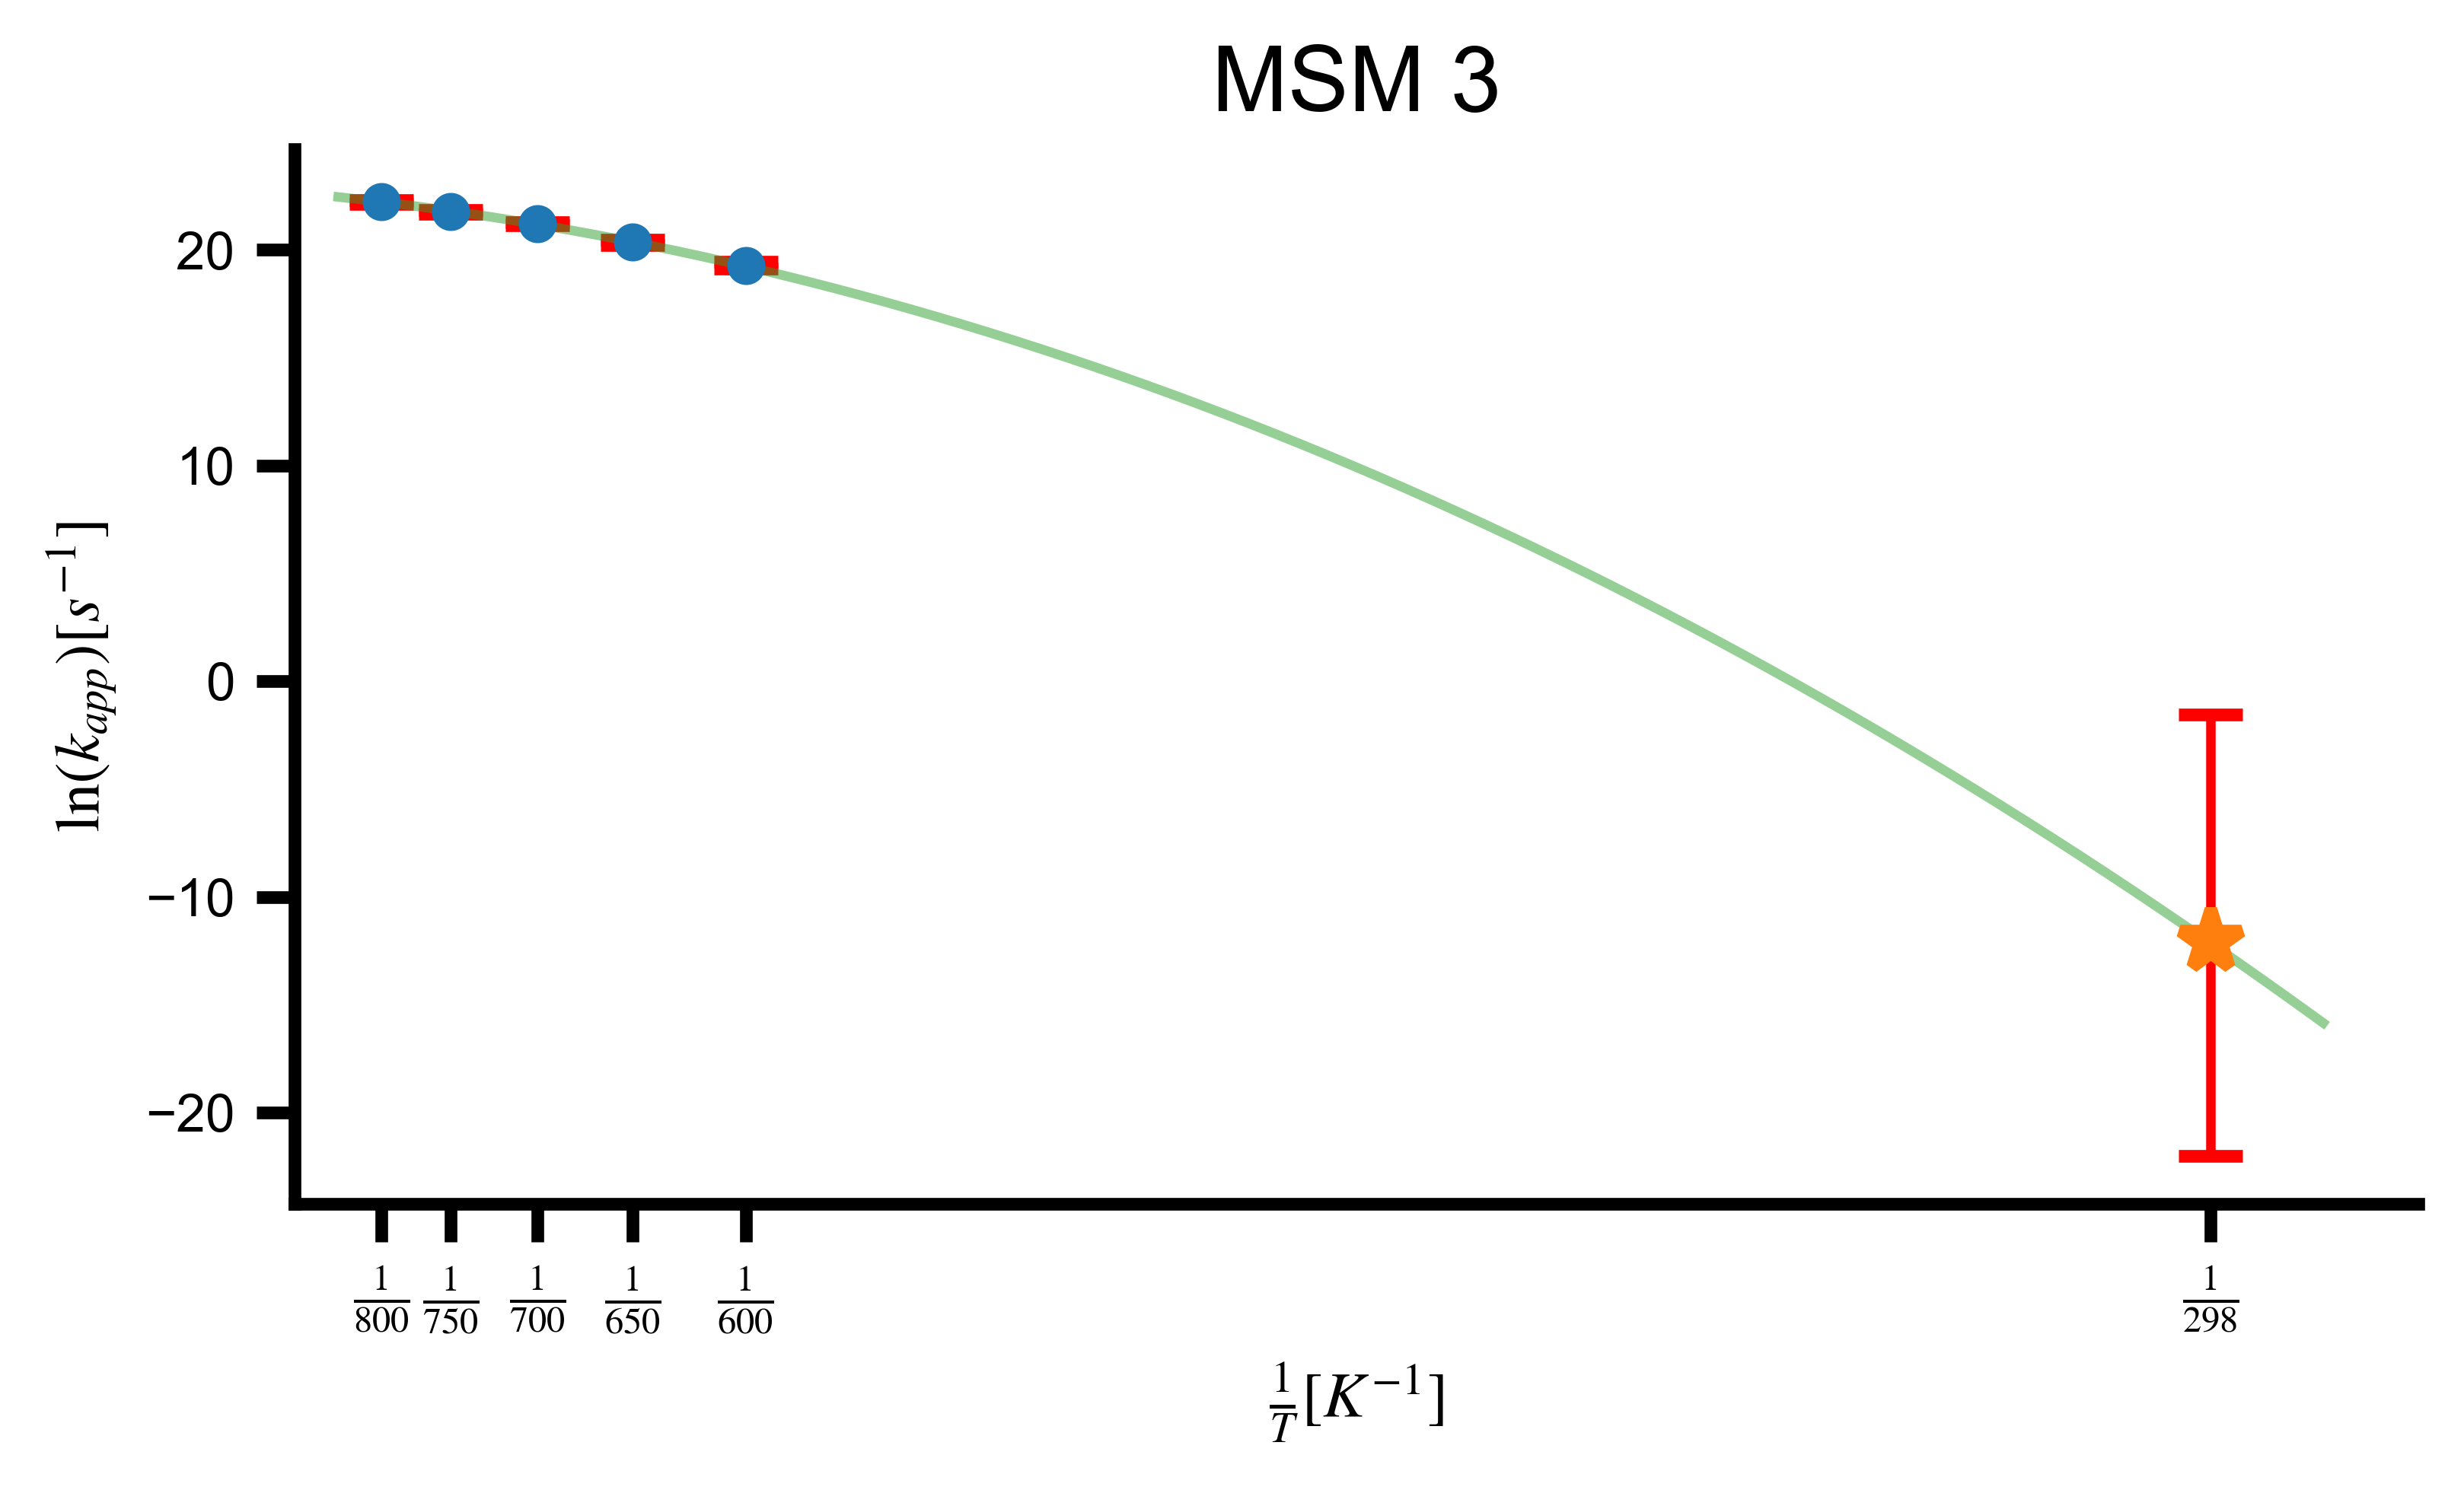

In [11]:
# import numpy as np
# import matplotlib.pyplot as plt

# Define the data as a multiline string
data = """0.00125 22.226 22.146 22.309
0.00133 21.775 21.687 21.864
0.00143 21.217 21.135 21.301
0.00154 20.357 20.239 20.479
0.00167 19.276 19.125 19.440
0.00336 -12.023 -21.999 -1.558"""

T_range=np.arange(0.0012, 0.0035, 0.00001)

# Parse the data
lines = data.split('\n')
x = []
mean = []
lower_bound = []
upper_bound = []

for line in lines:
    cols = line.split()
    x.append(float(cols[0]))
    mean.append(float(cols[1]))
    lower_bound.append(float(cols[2]))
    upper_bound.append(float(cols[3]))

x = np.array(x)
mean = np.array(mean)
lower_bound = np.array(lower_bound)
upper_bound = np.array(upper_bound)

# Calculate the error values
error_lower = mean - lower_bound
error_upper = upper_bound - mean
errors = [error_lower, error_upper]

x_labels = [r'$\frac{1}{800}$', r'$\frac{1}{750}$', r'$\frac{1}{700}$', r'$\frac{1}{650}$', r'$\frac{1}{600}$', r'$\frac{1}{298}$']

# Plot the data with error bars
plt.figure(figsize=(6, 3))

plt.errorbar(x[:-1], mean[:-1], yerr=[error_lower[:-1], error_upper[:-1]], fmt='o', ecolor='red', capsize=5, capthick=2, markeredgewidth=2)
# plot extrapolated point, T=298K
plt.errorbar(x[-1], mean[-1], yerr=[[error_lower[-1]], [error_upper[-1]]], fmt='*', ecolor='red', capsize=5, capthick=2, markeredgewidth=2, markersize=10)


plt.plot(T_range, quadratic_fun(T_range, *mean_res[3]), alpha=0.5)
plt.xlabel(r'$\frac{1}{T}[K^{-1}]$')
plt.ylabel(r'$\ln(k_{app})[s^{-1}]$')

# Set the x-ticks and x-tick labels
plt.xticks(ticks=x, labels=x_labels)
plt.xlim(0.00115, 0.0036)

plt.title('MSM 3')
# plt.grid(True)
# plt.show()
plt.savefig('MSM3.png', dpi=1000)

In [12]:
T_range=np.arange(0.0012, 0.0035, 0.00001)
fx_fit = quadratic_fun(T_range, *mean_res[3])
datafitting = np.array([T_range, fx_fit]).T
np.savetxt(f'function_{state}.dat', datafitting, delimiter='\t', fmt = '%10.5f')